In [3]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
sns.set_style("whitegrid")

from synexp import *
from viz import *


### Setup

- $X \in [-1, 1]$ is a unidimensional co-variate
- Target potential outcome (PO) class probabilities $\eta^*_0(x), \eta^*_1(x)$ are piecewise sinusoidal functions satisfying weak seperability

- $\pi(x)=.2 x +.4$ is linear and correlated with $\eta^*_0(x)$. Specifically, cases at high risk under no intervention are also most likely to receive intervention

- Error parameters sampled randomly $\alpha_d, \beta_d \sim U(.01,.24)$

<!-- <img src="attachment:image-3.png" width="300"/> <img src="attachment:image-2.png" width="300"/>  -->

 
### Data generating process:

1. $Y^*_0, Y^*_1 \sim $ Bern($\eta^*_0(x)$), Bern($\eta^*_1(x)$), $\forall x \in X$
2. Sample errors $\alpha_d, \beta_d \sim U(.01,.24) \forall d \in D$
3. Flip $Y^*_d$, $Y^*_1$ based errors on $\alpha_d, \beta_d \forall d \in D$
4. Sample $D=d$ from $Bern(pi(x))$, $\forall x \in X$
5. Observe potential outcomes $Y=Y_0(1-D) + Y_1(D)$, $Y^*=Y_0^*(1-D) + Y_1^*(D)$

## Experiments


#### Model comparision
- $\hat{P}[Y=1|X=x]$ (observational)
- $\hat{P}_{\ell}[Y=1|D=d,X=x]$ (conditional outcome)
- $\hat{P}_{\tilde{\ell}}[Y=1|D=d,X=x]$ (**ours:** conditional outcome with surrogate loss)
- $\hat{P}[Y_d=1|X=x]$ (proxy PO oracle)
- $\hat{P}[Y^*_d=1|X=x]$ (target PO oracle)

Metrics: 
- Accuracy, AU-ROC, FPR/FNR w.r.t $Y^*_d$

#### Parameter estimation experiment (test of CCPE approach)
- Plot parameter estimation error as a function of sample size
- Show more estimation error in $\beta_0$ term when D non-random ($\pi$ non-uniform)

#### Robustness to parameter estimation error
- Performance of surrogate loss as a functon of parameter estimation error








In [17]:
Y0_PDF = 'piecewise_sinusoid'
Y1_PDF = 'low_base_rate_sinusoid'
PI_PDF = 'linear'

# Example code invoking experiemnt setup functions
expdf, error_params = generate_syn_data(
    NS=5000,
    K=1,
    y0_pdf=Y0_PDF,
    y1_pdf=Y1_PDF,
    pi_pdf=PI_PDF,
    error_min=0.24,
    error_max=0.25
)
# Sanity check
# results, val_scores = run_baseline_comparison_exp(expdf, do=0,
#                                            error_params=error_params, n_epochs=20, train_ratio=.7)

## Main Experiment: Validating factual surrogate loss correction

In [ ]:
do=0
N_RUNS=3
NS=10000
n_epochs=40
baselines = [{
    'model': 'Observational',
    'target': 'Y0'
},{
    'model': 'Conditional outcome',
    'target': 'Y0'
},{
    'model': 'Conditional outcome (SL)',
    'target': 'Y0'
},{
    'model': 'Proxy PO Oracle',
    'target': f'Y0_{do}'
},{
    'model': 'Target PO Oracle',
    'target': f'YS_{do}'
}]

# Run this during the meeting #
exp_results = run_baseline_comparison_exp_grid(
    baselines,
    do=do,
    N_RUNS=N_RUNS,
    NS=NS,
    pi_pdf='linear',
    K=1,
    n_epochs=n_epochs
)

resultdf = pd.DataFrame(exp_results)
resultdf.to_csv(f'results/exp1_results_NR={N_RUNS}_NS={NS}_E={n_epochs}.csv',
                index=False)


In [4]:
print(resultdf.groupby('model').mean())

sns.set(font_scale=1.2)
g=sns.barplot(data=resultdf[resultdf['alpha'] == .3], x='model', y='ACC', capsize=.2)
plt.xticks(rotation=45)
plt.ylabel('AU-ROC')
plt.xlabel('')

sns.set(font_scale=1.2)
g=sns.barplot(data=resdf, x='model', y='ACC', capsize=.2)
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('')

,AU-ROC,ACC,alpha,beta
model,,,,
Conditional outcome,0.836203,0.745778,0.05064,0.200582
Conditional outcome (SL),0.791430,0.731667,0.05064,0.200582
Observational,0.576098,0.567444,0.05064,0.200582
Proxy PO Oracle,0.826703,0.757667,0.05064,0.200582
Target PO Oracle,0.851351,0.769333,0.05064,0.200582


## Main experiment 1: cross method comparison

In [17]:
resdf = pd.read_csv('results/exp1_grid_results_NR=10_NS=10000_E=40.csv')
means = resdf.groupby(['alpha', 'beta', 'model']).mean()['ACC']
print(means.to_latex())

stds = resdf.groupby(['alpha', 'beta', 'model']).std()['ACC']
print(stds.to_latex())


\begin{tabular}{lllr}
\toprule
    &     &                  &       ACC \\
alpha & beta & model &           \\
\midrule
0.0 & 0.0 & Conditional outcome &  0.756200 \\
    &     & Conditional outcome (SL) &  0.771900 \\
    &     & Observational &  0.556967 \\
    &     & Proxy PO Oracle &  0.755400 \\
    &     & Target PO Oracle &  0.726600 \\
0.1 & 0.3 & Conditional outcome &  0.630800 \\
    &     & Conditional outcome (SL) &  0.762400 \\
    &     & Observational &  0.545800 \\
    &     & Proxy PO Oracle &  0.658467 \\
    &     & Target PO Oracle &  0.757900 \\
0.3 & 0.1 & Conditional outcome &  0.679267 \\
    &     & Conditional outcome (SL) &  0.730867 \\
    &     & Observational &  0.585333 \\
    &     & Proxy PO Oracle &  0.646400 \\
    &     & Target PO Oracle &  0.729533 \\
\bottomrule
\end{tabular}

\begin{tabular}{lllr}
\toprule
    &     &                  &       ACC \\
alpha & beta & model &           \\
\midrule
0.0 & 0.0 & Conditional outcome &  0.034641 \\
    &

/var/folders/w_/rwxvw5hn1ng2qvm6353gkvqw0000gr/T/ipykernel_38091/3849574071.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(means.to_latex())
/var/folders/w_/rwxvw5hn1ng2qvm6353gkvqw0000gr/T/ipykernel_38091/3849574071.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stds.to_latex())


## Main Experiment: parameter estimation via CCPE

In [ ]:
SAMPLE_SIZES = [1000, 2000, 3000, 4000, 5000, 10000, 20000]
exp_results, py_results = ccpe_benchmark_exp(SAMPLE_SIZES, N_RUNS=150, K=1, n_epochs=30)
result_df = get_ccpe_result_df(do=1, exp_results=exp_results)

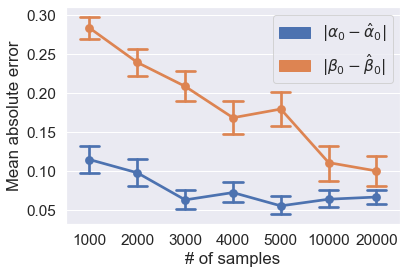

In [42]:
result_df = pd.read_csv('results/R7_K=1_N_RUNS=150_n_epochs=30_d0.csv')
result_df = result_df[result_df['aggregate'] == False]
g = sns.pointplot(
    data=result_df,
    x='NS',
    y='error',
    hue='parameter',
    capsize=.4,
    legend=True
)
g.set(xlabel='# of samples', ylabel='Mean absolute error')
red_patch = mpatches.Patch(color=sns.color_palette()[0], label=r'$|\alpha_0 - \hat{\alpha}_0|$')
black_patch = mpatches.Patch(color=sns.color_palette()[1], label=r'$|\beta_0 - \hat{\beta}_0|$')
plt.legend(handles=[red_patch, black_patch])
sns.set(font_scale=1.6)
plt.savefig('figs/estimation_error.png', dpi=500, bbox_inches='tight')


## Experiment: Robustness to parameter estimation Error

In [5]:
params = np.array([0, .2, .4])
errors = np.array([-.2, -.15, -.1, -.05, 0, .05, .1, .15, .2])
configs = []

for param in params: 
    for error in errors:
        estimate = round(param+error, 2)
        if estimate>=0 and estimate<=.5:
            configs.append({
                'param': param,
                'estimate': estimate
            })

exp_results = run_estimation_error_exp(do=0, param_configs=configs, error_param='alpha',
                                       NS=5000, N_RUNS=1, n_epochs=5, train_ratio=.7)

surroate params {'alpha': 0.0, 'beta': 0}


Target: Y0: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]


surroate params {'alpha': 0.05, 'beta': 0}


Target: Y0: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.43it/s]


surroate params {'alpha': 0.1, 'beta': 0}


Target: Y0: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.24it/s]


surroate params {'alpha': 0.15, 'beta': 0}


Target: Y0: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.07s/it]


surroate params {'alpha': 0.2, 'beta': 0}


Target: Y0: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.30it/s]


surroate params {'alpha': 0.0, 'beta': 0}


Target: Y0: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.05s/it]


surroate params {'alpha': 0.05, 'beta': 0}


Target: Y0: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.24it/s]


surroate params {'alpha': 0.1, 'beta': 0}


Target: Y0: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


surroate params {'alpha': 0.15, 'beta': 0}


Target: Y0: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.29it/s]


surroate params {'alpha': 0.2, 'beta': 0}


Target: Y0: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.35it/s]


surroate params {'alpha': 0.25, 'beta': 0}


Target: Y0: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.34it/s]


surroate params {'alpha': 0.3, 'beta': 0}


Target: Y0: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.38it/s]


surroate params {'alpha': 0.35, 'beta': 0}


Target: Y0: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.40it/s]


surroate params {'alpha': 0.4, 'beta': 0}


Target: Y0: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s]


surroate params {'alpha': 0.2, 'beta': 0}


Target: Y0: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44it/s]


surroate params {'alpha': 0.25, 'beta': 0}


Target: Y0: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]


surroate params {'alpha': 0.3, 'beta': 0}


Target: Y0: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.34it/s]


surroate params {'alpha': 0.35, 'beta': 0}


Target: Y0: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.33it/s]


surroate params {'alpha': 0.4, 'beta': 0}


Target: Y0: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.35it/s]


surroate params {'alpha': 0.45, 'beta': 0}


Target: Y0: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44it/s]


surroate params {'alpha': 0.5, 'beta': 0}


Target: Y0: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.48it/s]


<AxesSubplot:xlabel='alpha', ylabel='ACC'>

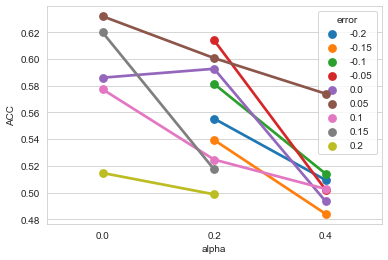

In [12]:
robustness_results = pd.DataFrame(exp_results)
robustness_results['error'] = (robustness_results['alpha_hat'] - robustness_results['alpha'].tolist()).round(decimals=2)
sns.pointplot(data=robustness_results, x='alpha', y='ACC', hue='error')



In [8]:
robustness_results['param'] = 'alpha'
robustness_results

,AU-ROC,ACC,alpha,beta,alpha_hat,beta_hat,error,param
0,0.605695,0.586000,0.0,0,0.00,0,0.00,alpha
1,0.631946,0.632000,0.0,0,0.05,0,0.05,alpha
2,0.584003,0.577333,0.0,0,0.10,0,0.10,alpha
3,0.620377,0.620000,0.0,0,0.15,0,0.15,alpha
4,0.621954,0.514667,0.0,0,0.20,0,0.20,alpha
5,0.633439,0.555333,0.2,0,0.00,0,-0.20,alpha
6,0.614077,0.539333,0.2,0,0.05,0,-0.15,alpha
7,0.624499,0.581333,0.2,0,0.10,0,-0.10,alpha
8,0.628612,0.614000,0.2,0,0.15,0,-0.05,alpha
9,0.629790,0.592667,0.2,0,0.20,0,0.00,alpha


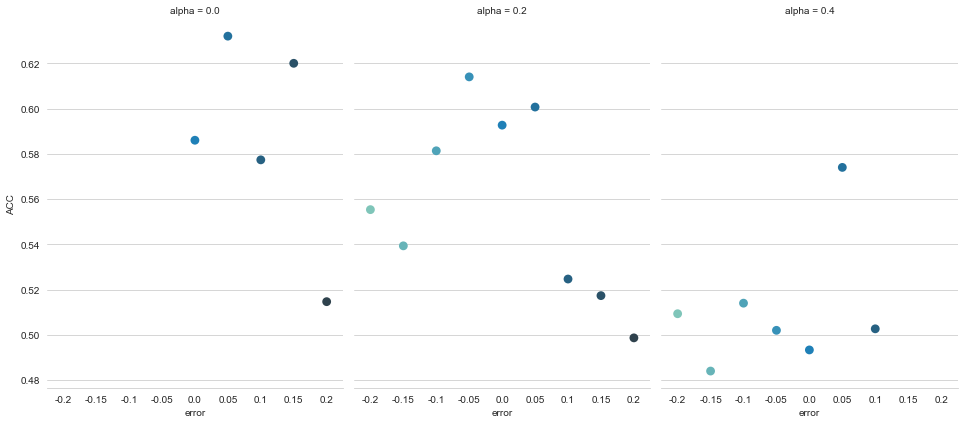

In [17]:


# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(
    data=robustness_results, x="error", y="ACC",  col="alpha",
    capsize=.2, palette="YlGnBu_d", errorbar="se",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)



## Debugging baselines

In [ ]:
compare
alpha:0, beta:0 [looks good]
alpha:.1, beta.3 [looks good]
alpha:.2, beta:.2
alpha:.3, beta.1 [looks good]


In [7]:
## Main Experiment: troubleshoot baselines
    
    
Y0_PDF = 'piecewise_sinusoid'
Y1_PDF = 'low_base_rate_sinusoid'
PI_PDF = 'linear'
do=0

expdf, error_params = generate_syn_data(
    NS=10000,
    K=1,
    y0_pdf=Y0_PDF,
    y1_pdf=Y1_PDF,
    pi_pdf=PI_PDF,
    alpha_min=0.1,
    alpha_max=0.11,
    beta_min=0.3,
    beta_max=0.31,
    shuffle=True
)

baseline1 = {
    'model': 'Conditional outcome',
    'target': 'Y0'
}

baseline2 = {
    'model': 'Conditional outcome (SL)',
    'target': 'Y0'
}

params1 = {
    'alpha': None,
    'beta': None
}

params2 = {
    'alpha': error_params[f'alpha_{do}'][0],
    'beta': error_params[f'beta_{do}'][0]
}

co = run_baseline(expdf, baseline1, do, params1, n_epochs=20, train_ratio=.7)
cosl = run_baseline(expdf, baseline2, do, params2, n_epochs=20, train_ratio=.7)



surroate params {'alpha': None, 'beta': None}


Target: Y0: 100%|█████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.35it/s]


surroate params {'alpha': 0.10648197887660037, 'beta': 0.30984503179487555}


Target: Y0: 100%|█████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.37it/s]


In [8]:
agreement = [(co['py_hat'] > .5) == (cosl['py_hat'] > .5)][0].mean()
print(f'aggreement (%): {agreement.mean():.2f}')
print(f"ACC - S0={co['ACC']:.2f}, SO+SL={cosl['ACC']:.2f}")
print(f"AU-ROC - S0={co['AU-ROC']:.2f}, SO+SL={cosl['AU-ROC']:.2f}")

aggreement (%): 0.65
ACC - S0=0.59, SO+SL=0.77
AU-ROC - S0=0.81, SO+SL=0.83


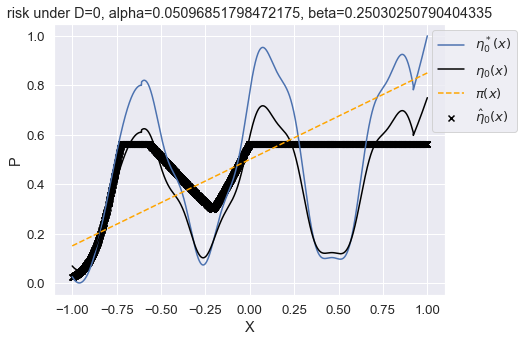

In [10]:
Y0_PDF = 'piecewise_sinusoid'
Y1_PDF = 'low_base_rate_sinusoid'
PI_PDF = 'linear'
do=0

expdf, _ = generate_syn_data(
    NS=10000,
    K=1,
    y0_pdf=Y0_PDF,
    y1_pdf=Y1_PDF,
    pi_pdf=PI_PDF,
)
debug_info = {
    'val_x': cosl['x'].squeeze(),
    'val_py': cosl['py_hat'].squeeze()
}
# debug_info = {
#     'val_x': x,
#     'val_py': py_hat
# }
sns.set(font_scale=1.2)
viz_ccpe_estimates(expdf, debug_info, error_params[f'alpha_{do}'][0],
                   error_params[f'beta_{do}'][0], do, Y0_PDF, Y1_PDF, PI_PDF)

In [28]:
expdf, error_params = generate_syn_data(
    NS=10000,
    K=1,
    y0_pdf=Y0_PDF,
    y1_pdf=Y1_PDF,
    pi_pdf=PI_PDF,
    error_min=0.2,
    error_max=0.2, 
    shuffle=True
)

split_ix = int(expdf.shape[0]*.7)
train_df, val_df = expdf.iloc[:split_ix,:], expdf.iloc[split_ix:,:]


# Train model
train_loader, val_loader = get_loaders(train_df, val_df, do=0, target='Y0', conditional=True)
model = MLP()

surrogate_params = {
    'alpha': 0.2,
    'beta': 0.2
}

# surrogate_params = {
#     'alpha': None,
#     'beta': None
# }

losses = train(model, target='Y0', train_loader=train_loader, error_params=surrogate_params, n_epochs=40)

# Evaluate on validation data
x, y, py_hat = evaluate(model, val_loader)
y_hat = np.zeros_like(y)
y_hat[py_hat > .5] = 1

TypeError: generate_syn_data() got an unexpected keyword argument 'error_min'

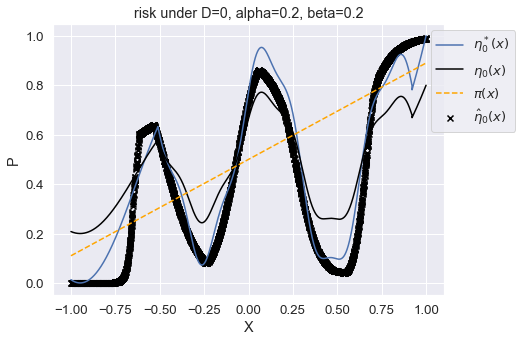

In [23]:
def get_loss(y_hat, y, alpha_d=None, beta_d=None):

    loss = torch.nn.BCELoss()
    if not alpha_d:
        return loss(y_hat, y) 

    pos_loss = loss(y_hat[y==1], y[y==1])
    neg_loss = loss(y_hat[y==0], y[y==0])

    pos_label_losses = ((1-alpha_d)*pos_loss - beta_d*neg_loss)/(1-beta_d-alpha_d)
    neg_label_losses = ((1-beta_d)*neg_loss - alpha_d*pos_loss)/(1-beta_d-alpha_d)

    return pos_label_losses + neg_label_losses
